In [9]:
import torch.nn as nn
import torch
import timm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [28]:
def __init__(self, params):
    super(Net, self).__init__()
    
    C_in,H_in,W_in=params["input_shape"] 
    self.dropout_rate=params["drop_rate"] 
    self.num_fc1 = params["num_fc1"]

    mobilenet_v2 = torchvision.models.mobilenet_v2(pretrained=True) 
    
    in_features = mobilenet_v2.classifier[1].in_features
    
    mobilenet_v2.classifier[1] = nn.Linear(in_features, self.num_fc1)
    
    self.backbone = nn.Sequential(
                    mobilenet_v2,
                    nn.BatchNorm1d(num_features=self.num_fc1),
                    nn.ReLU()
    )
    
    self.gender_head = nn.Sequential(
                            nn.Dropout(p=self.dropout_rate),
                            nn.Linear(self.num_fc1, 1),
                            nn.Sigmoid()
    )
    
    self.age_head = nn.Sequential(
                    nn.Linear(self.num_fc1, 1)
    )


In [29]:
def forward(self, x):
    x = self.backbone(x)  
    
    gender = self.gender_head(x)
    age = self.age_head(x)
    
    return age, gender

In [34]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,224,224),
        "drop_rate" : 0.2,
        "num_fc1" : 512,
    }

model = Net(params_model)

# def replace_nnHar_to_SiLU(model):
#     for child_name, child in model.named_children():
#         if isinstance(child, nn.SiLU):
#             setattr(model, child_name, SiLU())
#         else:
#             replace_nnSiLU_to_SiLU(child)
            
# replace_nnSiLU_to_SiLU(model)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

Let's use 4 GPUs!


In [35]:
checkpoint = torch.load('../models/exp_2021_01_13-15_40_32/best_checkpoints.bin')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [36]:
if isinstance(model, torch.nn.DataParallel):
        model = model.module

In [39]:
torch.save(model.state_dict(), '../models/age_gender_mobilev2.pt')

In [13]:
model.eval()

Net(
  (backbone): Sequential(
    (0): MobileNetV2(
      (features): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
            )
            (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (2): InvertedResidual(
          (conv): Sequential(
            (0): ConvBNReLU(
              (0): Con

In [14]:
import torch.onnx

In [15]:
# Input to the model
batch_size = 1    # just a random number

x = torch.randn(1, 3, 224, 224, requires_grad=True)
torch_out = model(x)

ONNX_PATH = '../models/age_gender_mobilenet_v2.onnx'

# Export the model
torch.onnx.export(
                  model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  f = ONNX_PATH,   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  verbose = False,
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output_age', 'output_gender'] # the model's output names
                 )

In [16]:
torch.__version__

'1.7.0'

In [17]:
import onnx

onnx_model = onnx.load("../models/age_gender_mobilenet_v2.onnx")
onnx.checker.check_model(onnx_model)

In [18]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("../models/age_gender_mobilenet_v2.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
for i, result in enumerate(torch_out):
    np.testing.assert_allclose(to_numpy(result), ort_outs[i], rtol=1e-03, atol=1e-05)
    print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!
Exported model has been tested with ONNXRuntime, and the result looks good!


In [19]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
        ToTensorV2(),
    ])

df = pd.read_csv("/home/Data/all/testing.csv")
img = cv2.imread(df['file_name'][500], cv2.IMREAD_COLOR)

out = img.copy()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')

img /= 255.0

img = get_val_transforms()(image = img)['image']

age, gender = df['age'][0], df['gender'][0]

img = torch.unsqueeze(img, 0)

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)
img_out_age = ort_outs[0]
img_out_gd = ort_outs[1]

Text(0.5, 1.0, 'Age :21-[[28.305607]], Gender: 0-[[0.8280318]]')

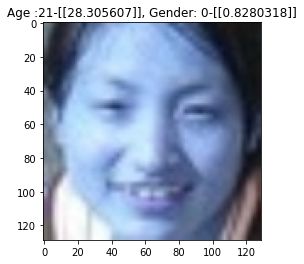

In [20]:
plt.imshow(out)
plt.title(f'Age :{age}-{img_out_age}, Gender: {gender}-{img_out_gd}')

In [25]:
from onnx_tf.backend import prepare
import onnx

ONNX_PATH = '../models/age_gender_mobilenet_v2.onnx'

onnx_model = onnx.load(ONNX_PATH)

tf_rep = prepare(onnx_model, logging_level ='DEBUG', strict = False)

# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

2021-01-13 18:15:08,700 - onnx-tf - INFO - Unknown op ConstantFill in domain `ai.onnx`.
INFO:onnx-tf:Unknown op ConstantFill in domain `ai.onnx`.
2021-01-13 18:15:08,703 - onnx-tf - INFO - Unknown op ImageScaler in domain `ai.onnx`.
INFO:onnx-tf:Unknown op ImageScaler in domain `ai.onnx`.


inputs: ['input']
outputs: ['output_age', 'output_gender']
tensor_dict:
{'559': <tf.Tensor '559:0' shape=(32, 3, 3, 3) dtype=float32>, '560': <tf.Tensor '560:0' shape=(32,) dtype=float32>, '562': <tf.Tensor '562:0' shape=(32, 1, 3, 3) dtype=float32>, '563': <tf.Tensor '563:0' shape=(32,) dtype=float32>, '565': <tf.Tensor '565:0' shape=(16, 32, 1, 1) dtype=float32>, '566': <tf.Tensor '566:0' shape=(16,) dtype=float32>, '568': <tf.Tensor '568:0' shape=(96, 16, 1, 1) dtype=float32>, '569': <tf.Tensor '569:0' shape=(96,) dtype=float32>, '571': <tf.Tensor '571:0' shape=(96, 1, 3, 3) dtype=float32>, '572': <tf.Tensor '572:0' shape=(96,) dtype=float32>, '574': <tf.Tensor '574:0' shape=(24, 96, 1, 1) dtype=float32>, '575': <tf.Tensor '575:0' shape=(24,) dtype=float32>, '577': <tf.Tensor '577:0' shape=(144, 24, 1, 1) dtype=float32>, '578': <tf.Tensor '578:0' shape=(144,) dtype=float32>, '580': <tf.Tensor '580:0' shape=(144, 1, 3, 3) dtype=float32>, '581': <tf.Tensor '581:0' shape=(144,) dtype=f

In [22]:
import numpy as np
from IPython.display import display
from PIL import Image

# prepare input data
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
    ])

df = pd.read_csv("/home/Data/all/testing.csv")
img = cv2.imread(df['file_name'][500], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32')

img /= 255.0

img = get_val_transforms()(image = img)['image']

output = tf_rep.run(np.transpose(np.asarray(img, dtype=np.float32)[np.newaxis ,: , :, :], (0, 3, 1, 2)))
print('Age {}, Gender {} as '.format(output[0], output[1]))

Age [[28.305317]], Gender [[0.8279992]] as 


In [26]:
tf_rep.export_graph('../models/agegender_mobilenet_v2.pb')

In [27]:
import tensorflow as tf

TFLITE_PATH_V1 = '../models/age_gender_mixnet_v1.tflite'

graph_file = '../models/agegender_mobilenet_v2.pb'

input_array = ['input'] # you need to change it based on your model
output_array = ['output_age', 'output_gender'] # you need to change it based on your model
print("{} -> {}".format(graph_file, TFLITE_PATH_V1))

converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
      graph_def_file=graph_file,
      input_arrays=input_array,
      output_arrays=output_array,
      input_shapes={'input' : [1, 3, 224, 224]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops=True
converter.experimental_new_converter =True

# I had to explicitly state the ops
converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]


tflite_quant_model = converter.convert()

with open(TFLITE_PATH_V1, 'wb') as f:
    f.write(tflite_quant_model)

../models/agegender_mobilenet_v2.pb -> ../models/age_gender_mixnet_v1.tflite


ConverterError: <unknown>:0: error: loc("BatchNormalization_175/mul_1"): 'tfl.fully_connected' op expect 2d filter, got 'tensor<1x512x1280xf32>'
<unknown>:0: note: loc("BatchNormalization_175/mul_1"): see current operation: %7397 = "tfl.fully_connected"(%7396, %cst_4436, %cst_4437) {fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"} : (tensor<1x1280xf32>, tensor<1x512x1280xf32>, tensor<1x512xf32>) -> tensor<1x512xf32>


In [ ]:
TFLITE_PATH_V2 = '../models/age_gender_mixnet_v2.tflite'
TFLITE_PATH_V3 = '../models/age_gender_mixnet_v3.tflite'